In [1]:
# !pip install torchcfm

In [1]:
!pip install git+https://github.com/manmeet3591/conditional-flow-matching

  Cloning https://github.com/manmeet3591/conditional-flow-matching to /tmp/pip-req-build-xtmd5itc
  Running command git clone --filter=blob:none --quiet https://github.com/manmeet3591/conditional-flow-matching /tmp/pip-req-build-xtmd5itc
  Resolved https://github.com/manmeet3591/conditional-flow-matching to commit 58ecad04508fd422e086d2df18d117280e3f6ddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.8/867.8 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# !git clone https://github.com/atong01/conditional-flow-matching

In [3]:
# %cd conditional-flow-matching
# !pip install requirements.txt
# !python setup.py install
# %cd ../

In [4]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 3

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.17MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
#################################
#            OT-CFM
#################################

sigma = 0.0
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1, in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters())
# FM = ConditionalFlowMatcher(sigma=sigma)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [7]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

468it [01:16,  6.14it/s]
468it [01:19,  5.92it/s]
468it [01:18,  5.93it/s]


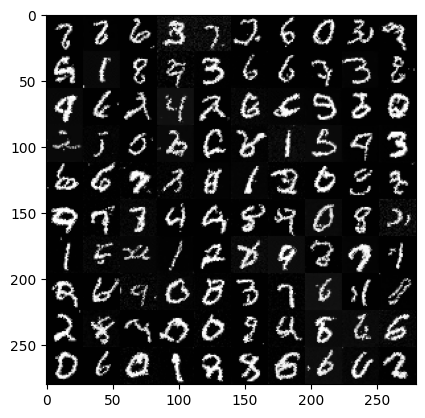

In [8]:
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 1, 28, 28, device=device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

# Conditional Flow Matching

In [9]:
x1.shape

torch.Size([128, 1, 28, 28])

In [10]:
torch.cat([x1,x1], dim=1).shape

torch.Size([128, 2, 28, 28])

In [12]:
#################################
#            OT-CFM
#################################

sigma = 0.0
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1, in_channels=2, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters())
# FM = ConditionalFlowMatcher(sigma=sigma)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [14]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, torch.cat([xt,x1], dim=1))
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

468it [01:19,  5.89it/s]
468it [01:19,  5.91it/s]
468it [01:19,  5.91it/s]
